<a href="https://colab.research.google.com/github/piotrciechowicz/spaceship_titanic/blob/main/spaceship_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
!pip install catboost
from catboost import CatBoostClassifier
import torch
from tqdm import tqdm
!pip install optuna
import optuna

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report, roc_curve, roc_auc_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Functions

In [94]:
def plot_histplot(data,x):
  fig, ax = plt.subplots(figsize = (10,4))
  sns.histplot(data = data, x = x, hue='Transported', kde=True)
  ax.set_title(f'{feat} distribution')
  print('\n')
  plt.show()

In [95]:
def plot_histplot_with_lim(data,x,lim):
  fig, ax = plt.subplots(figsize = (10,4))
  sns.histplot(data = data, x = x, hue='Transported', kde=True, bins=20)
  ax.set_title(f'{feat} distribution')
  plt.ylim([0,lim])
  print('\n')
  plt.show()

In [96]:
def plot_countplot(data,x):
  fig, ax = plt.subplots(figsize = (10,4))
  sns.countplot(data = data, x = x, hue='Transported')
  ax.set_title(f'Counts of {feat}')
  print('\n')
  plt.show()

In [97]:
def use_model(model, X_train, y_train, X_val, y_val):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)
  print(f'model: {str(model)}') 
  print('\n')
  print(f'Accuracy_score: {round(accuracy_score(y_val,y_pred)*100,2)} %')
  print(f'Precission_score: {round(precision_score(y_val,y_pred)*100,2)} %')
  print(f'Recall_score: {round(recall_score(y_val,y_pred)*100,2)} %')
  print(f'F1-score: {round(f1_score(y_val,y_pred)*100,2)} %')
  print('-'*80, '\n')

In [98]:
def calculate_auc(model, X_test, y_test):
  y_pred_proba = model.predict_proba(X_test)[::,1]
  fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
  auc = roc_auc_score(y_test, y_pred_proba)
  plt.plot(fpr,tpr,label="AUC="+str(auc))
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc=4)
  plt.show()

#Importing dataset

In [99]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Codecool/Spaceship Titanic/Data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Codecool/Spaceship Titanic/Data/test.csv')
target_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Codecool/Spaceship Titanic/Data/sample_submission.csv')

In [100]:
print('Sample of train set:')
display(train.sample(5))
print('-'*80, '\n')
print('Sample of test set:')
display(test.sample(5))

Sample of train set:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
5856,6200_02,Europa,False,B/238/S,TRAPPIST-1e,26.0,False,0.0,9.0,0.0,3.0,2047.0,Weias Duckil,False
6702,7073_01,Earth,True,G/1161/S,TRAPPIST-1e,40.0,False,0.0,0.0,0.0,0.0,NaN,Glena Hahnstonsen,True
2203,2357_01,Earth,False,E/139/P,TRAPPIST-1e,20.0,False,0.0,409.0,994.0,215.0,0.0,Vandy Whitez,False
395,0435_01,Earth,True,G/62/S,TRAPPIST-1e,17.0,False,0.0,0.0,0.0,0.0,0.0,Allie Willynnedy,True
7016,7461_01,Europa,True,D/223/S,TRAPPIST-1e,35.0,False,0.0,0.0,0.0,0.0,0.0,Zavior Plaricit,True


-------------------------------------------------------------------------------- 

Sample of test set:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
1301,2794_03,Mars,False,F/579/P,TRAPPIST-1e,20.0,False,1.0,0.0,2638.0,0.0,0.0,Donut Mellé
1689,3618_04,Europa,False,A/41/S,TRAPPIST-1e,18.0,False,244.0,256.0,0.0,2675.0,89.0,Tach Poustive
698,1437_01,Earth,False,G/224/P,PSO J318.5-22,28.0,False,0.0,0.0,0.0,422.0,351.0,Alfrey Hodes
2358,5119_01,Mars,False,E/319/P,TRAPPIST-1e,26.0,False,6.0,0.0,1041.0,NaN,0.0,Wafox Sin
1832,3893_01,Mars,False,F/734/S,TRAPPIST-1e,68.0,False,2466.0,0.0,205.0,0.0,0.0,Toate Casty


In [101]:
print('Train set shape:', train.shape,', ', round(train.shape[0]/(train.shape[0] + test.shape[0])*100,2), '% of dataset')
print('Test set shape:', test.shape,', ', round(test.shape[0]/(train.shape[0] + test.shape[0])*100,2), '% of dataset')

Train set shape: (8693, 14) ,  67.02 % of dataset
Test set shape: (4277, 13) ,  32.98 % of dataset


In [102]:
print('Types of train set:')
print(train.dtypes)
print('-'*80, '\n')
print('Types of test set:')
print(test.dtypes)

Types of train set:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object
-------------------------------------------------------------------------------- 

Types of test set:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
dtype: object


In [103]:
print('No. of unique features in train set:')
print(train.nunique())
print('-'*80, '\n')
print('No. of unique features in test set:')
print(test.nunique())

No. of unique features in train set:
PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64
-------------------------------------------------------------------------------- 

No. of unique features in test set:
PassengerId     4277
HomePlanet         3
CryoSleep          2
Cabin           3265
Destination        3
Age               79
VIP                2
RoomService      842
FoodCourt        902
ShoppingMall     715
Spa              833
VRDeck           796
Name            4176
dtype: int64


In [104]:
num_feat = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'] 
cat_feat = ['HomePlanet','CryoSleep','Destination','VIP']

# Exploratory data analysis

##Dataset statistics

In [105]:
print('Statistics of train set:')
display(train.describe())
print('-'*80, '\n')
print('Statistics of test set:')
display(test.describe())

Statistics of train set:


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


-------------------------------------------------------------------------------- 

Statistics of test set:


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


##Missing values

In [106]:
print('Train set missing values:')
print(train.isnull().sum())
print('\n')
print('-'*80, '\n')
print('Test set missing values:')
print(test.isnull().sum())

Train set missing values:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


-------------------------------------------------------------------------------- 

Test set missing values:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


## Target distribution

In [107]:
train['Transported'].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

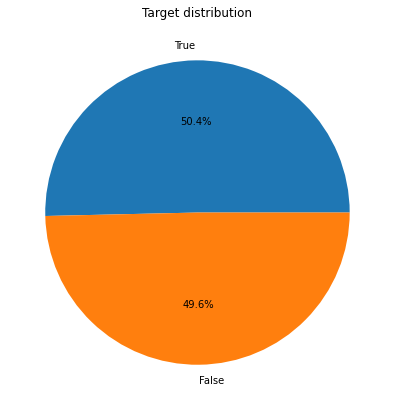

In [108]:
fig, ax = plt.subplots(figsize = (7,7))
ax.pie(train['Transported'].value_counts(),labels=['True','False'], autopct='%1.1f%%')
ax.set_title('Target distribution')
plt.show()

##Numerical features

In [109]:
num_feat

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

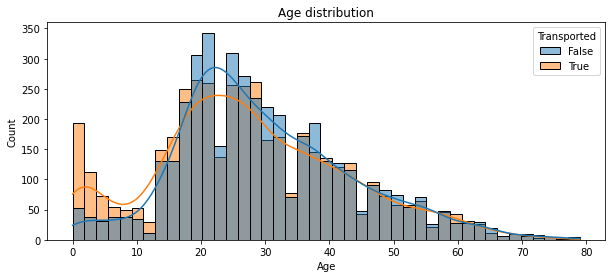

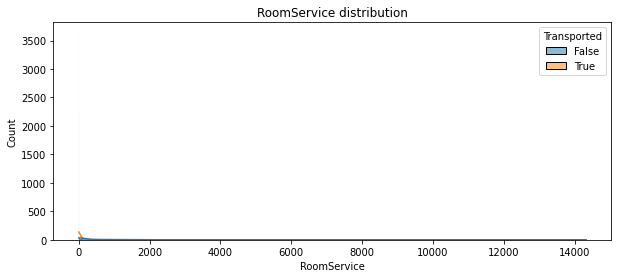

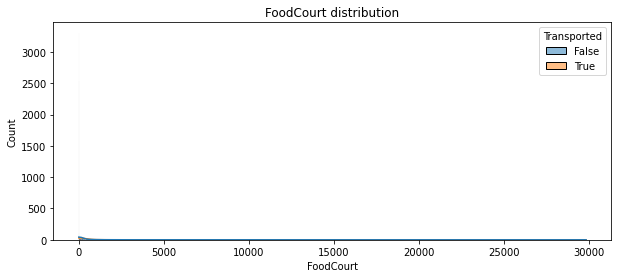

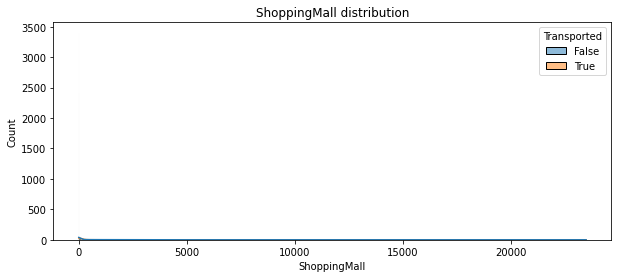

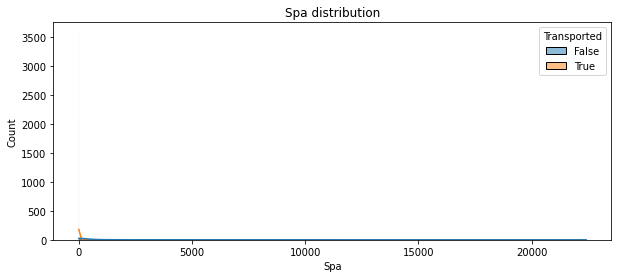

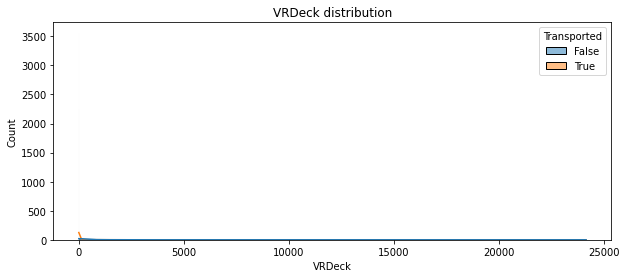

In [110]:
for feat in num_feat:
  plot_histplot(train, train[feat])

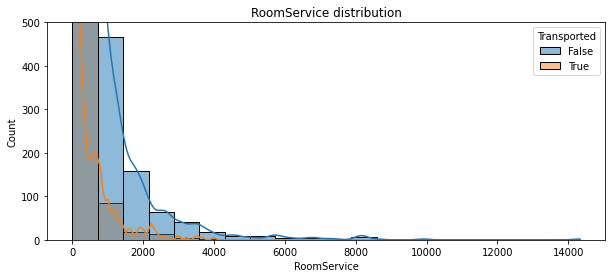

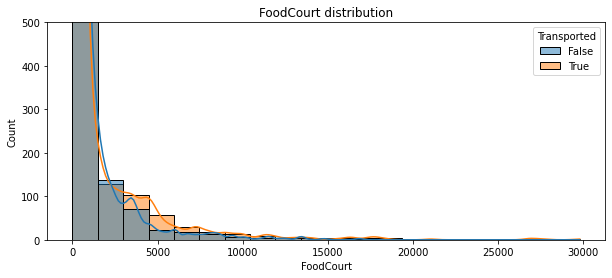

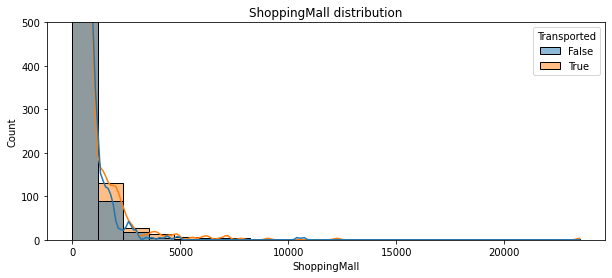

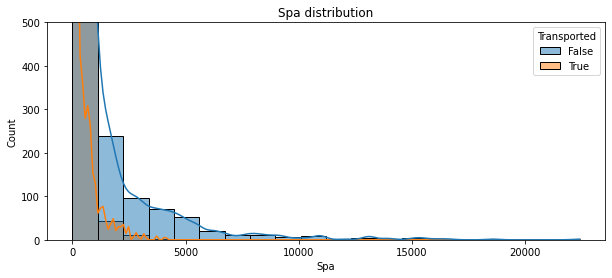

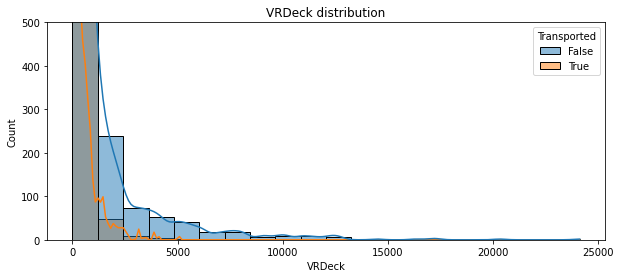

In [111]:
for feat in num_feat:
  if feat == 'Age':
    pass
  else:
    plot_histplot_with_lim(train, train[feat], 500)

##Categorical features

In [112]:
cat_feat

['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

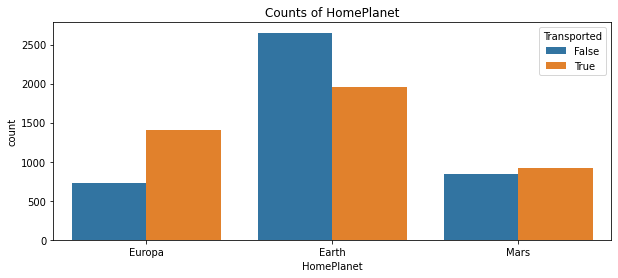

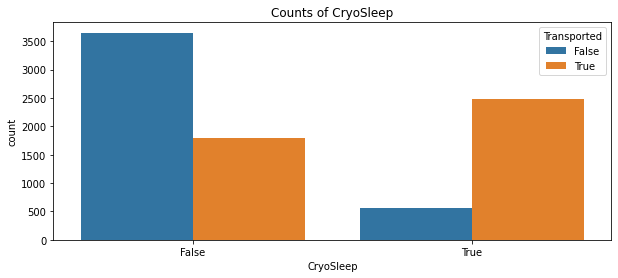

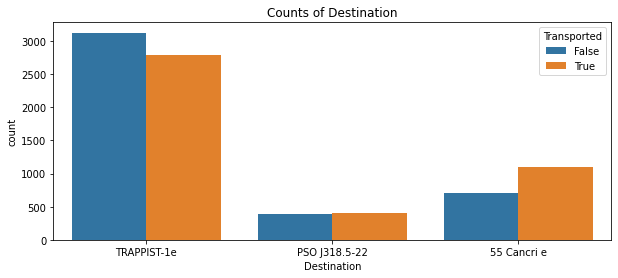

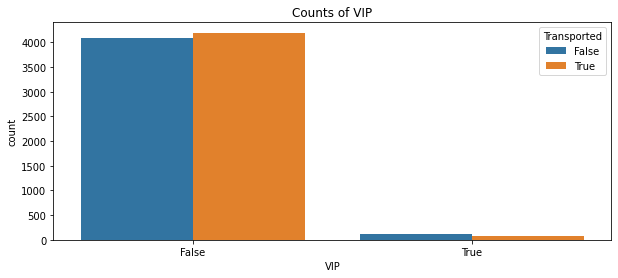

In [113]:
for feat in cat_feat:
  plot_countplot(train, train[feat])

##Map of correlation

<Axes: >

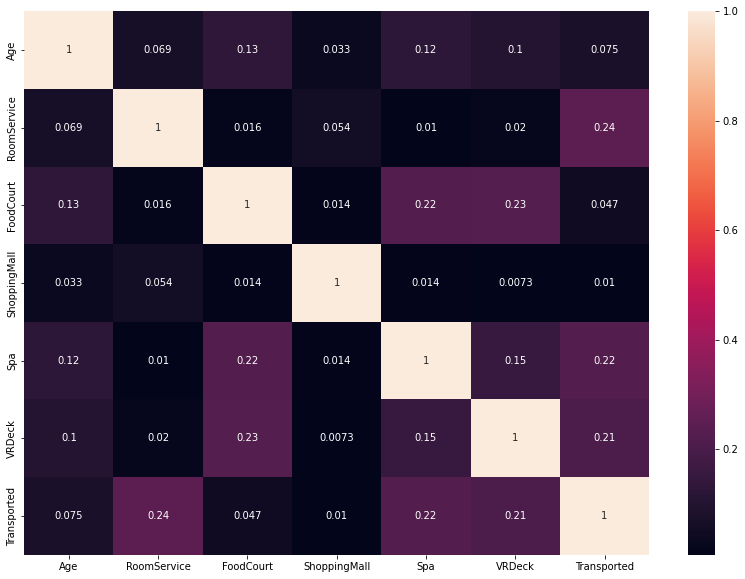

In [114]:
corr = train.corr()
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(np.abs(corr), annot=True)

##Pandas profiling

In [115]:
prof = ProfileReport(train)
prof.to_file(Path("/content/drive/MyDrive/Colab Notebooks/Codecool/Spaceship Titanic/pandas_profiling_report.html"))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]



```
# Sformatowano jako kod
```

#Feature engeneering

In [116]:
train_1 = train.drop(columns =['PassengerId','Cabin','Name','Transported'], axis=1)
test_1 = test.drop(columns =['PassengerId','Cabin','Name'], axis=1)

##Imputing missing values and encoding categorical features

In [117]:
y = train.replace({'Transported' : {False : 0, True : 1}},inplace=False)

In [118]:
imputer_1 = SimpleImputer(strategy='median')
imputer_1.fit(train_1[num_feat])
train_1[num_feat] = imputer_1.transform(train_1[num_feat])
test_1[num_feat] = imputer_1.transform(test_1[num_feat])

In [119]:
for col in cat_feat:
  fill_train = train_1[col].value_counts().idxmax()
  train_1[col].fillna(fill_train, inplace=True)
  fill_test = test_1[col].value_counts().idxmax()
  test_1[col].fillna(fill_test, inplace=True)

In [120]:
print('Train set missing values:')
print(train_1.isnull().sum())
print('\n')
print('-'*80, '\n')
print('Test set missing values:')
print(test_1.isnull().sum())

Train set missing values:
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


-------------------------------------------------------------------------------- 

Test set missing values:
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


In [121]:
train_2 = pd.get_dummies(data=train_1, columns = cat_feat)
test_2 = pd.get_dummies(data=test_1, columns = cat_feat)

In [122]:
print('Sample of train set:')
display(train_2.sample(5))
print('-'*80, '\n')
print('Sample of test set:')
display(test_2.sample(5))

Sample of train set:


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
5366,20.0,0.0,0.0,53.0,2.0,754.0,1,0,0,1,0,0,0,1,1,0
2813,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,1,1,0
3973,28.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,0,0,1,1,0
4826,26.0,7.0,751.0,0.0,38.0,0.0,1,0,0,1,0,1,0,0,1,0
1946,27.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,0,1,1,0


-------------------------------------------------------------------------------- 

Sample of test set:


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
2267,21.0,97.0,41.0,0.0,436.0,52.0,1,0,0,1,0,0,0,1,1,0
4038,24.0,555.0,0.0,1307.0,0.0,12.0,0,0,1,1,0,0,0,1,1,0
3628,20.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,0,0,1,1,0
1423,33.0,1726.0,0.0,2.0,0.0,50.0,1,0,0,1,0,0,0,1,1,0
1747,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,1,1,0


##StandardScaler

In [123]:
scaler = StandardScaler()
scaler.fit(train_2)
train_sc = scaler.transform(train_2)
train_sc_df = pd.DataFrame(data = train_sc,
                           columns = train_2.columns,
                           index = train_2.index)

test_sc = scaler.transform(test_2)
test_sc_df = pd.DataFrame(data = test_sc,
                           columns = test_2.columns,
                           index = test_2.index)

#Modeling

## Train, Val, Test set split

In [124]:
X_train, X_test, y_train, y_test = train_test_split(train_sc_df,y['Transported'], test_size = 0.8, random_state = 8)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 8)

##XGBClassifier

model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


Accuracy_score: 75.59 %
Precission_score: 76.21 %
Recall_score: 76.16 %
F1-score: 76.19 %
-------------------------------------------------------------------------------- 



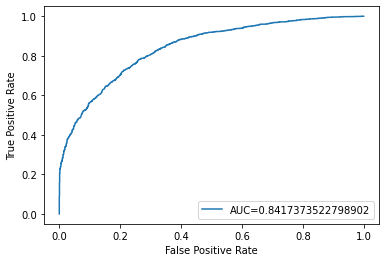

In [125]:
model_1 = XGBClassifier()
use_model(model_1, X_train, y_train, X_val, y_val)
calculate_auc(model_1, X_val, y_val)

##LGBMClassifier

model: LGBMClassifier()


Accuracy_score: 76.02 %
Precission_score: 75.86 %
Recall_score: 78.07 %
F1-score: 76.95 %
-------------------------------------------------------------------------------- 



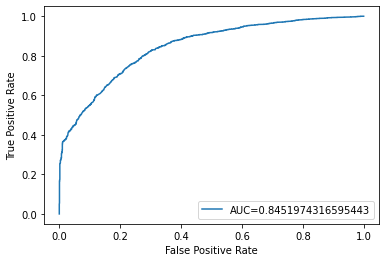

In [126]:
model_2 = LGBMClassifier()
use_model(model_2, X_train, y_train, X_val, y_val)
calculate_auc(model_2, X_val, y_val)

##CatBoostClassifier

Learning rate set to 0.013045
0:	learn: 0.6869519	total: 7.03ms	remaining: 7.02s
1:	learn: 0.6800498	total: 9.46ms	remaining: 4.72s
2:	learn: 0.6731823	total: 11.8ms	remaining: 3.93s
3:	learn: 0.6673924	total: 14.5ms	remaining: 3.6s
4:	learn: 0.6628138	total: 17ms	remaining: 3.38s
5:	learn: 0.6575707	total: 19.5ms	remaining: 3.23s
6:	learn: 0.6514373	total: 22.1ms	remaining: 3.13s
7:	learn: 0.6457456	total: 24.6ms	remaining: 3.05s
8:	learn: 0.6405906	total: 27.1ms	remaining: 2.99s
9:	learn: 0.6364359	total: 32ms	remaining: 3.17s
10:	learn: 0.6320513	total: 35.3ms	remaining: 3.17s
11:	learn: 0.6271992	total: 37.9ms	remaining: 3.12s
12:	learn: 0.6236820	total: 40.6ms	remaining: 3.08s
13:	learn: 0.6194609	total: 44.7ms	remaining: 3.15s
14:	learn: 0.6162996	total: 48ms	remaining: 3.15s
15:	learn: 0.6111512	total: 50.3ms	remaining: 3.09s
16:	learn: 0.6068679	total: 52.6ms	remaining: 3.04s
17:	learn: 0.6033665	total: 55.2ms	remaining: 3.01s
18:	learn: 0.5992094	total: 57.8ms	remaining: 2.98s

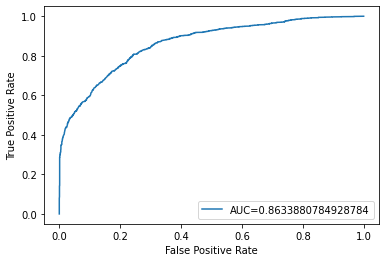

In [127]:
model_3 = CatBoostClassifier()
use_model(model_3, X_train, y_train, X_val, y_val)
calculate_auc(model_3, X_val, y_val)

##Optuna

In [128]:
def objective(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    model = CatBoostClassifier(**param)

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0, early_stopping_rounds=100)

    y_predict = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_predict)
    return accuracy

In [129]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, timeout=600)

[I 2023-03-26 10:59:22,662] A new study created in memory with name: no-name-b2fda220-e3c3-4741-adc2-9c8e1ec2b087
[I 2023-03-26 10:59:24,205] Trial 0 finished with value: 0.781196089706728 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.03398672632307756, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.781196089706728.
[I 2023-03-26 10:59:25,392] Trial 1 finished with value: 0.7561817136285222 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.012978323965464202, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.0772604224781794}. Best is trial 0 with value: 0.781196089706728.
[I 2023-03-26 10:59:29,152] Trial 2 finished with value: 0.7731454859114434 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.02054851319340676, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2077018282929212}. Best is trial 0 with value: 0

In [130]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 10
Best trial:
  Value: 0.7869465209890741
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.08089103350779048
    depth: 2
    boosting_type: Plain
    bootstrap_type: Bernoulli
    subsample: 0.6090357415395568


0:	learn: 0.6930848	total: 766us	remaining: 766ms
1:	learn: 0.6930865	total: 1.82ms	remaining: 909ms
2:	learn: 0.6877008	total: 2.7ms	remaining: 899ms
3:	learn: 0.6860259	total: 3.53ms	remaining: 879ms
4:	learn: 0.6852121	total: 4.72ms	remaining: 939ms
5:	learn: 0.6847488	total: 5.48ms	remaining: 909ms
6:	learn: 0.6796300	total: 6.33ms	remaining: 898ms
7:	learn: 0.6775132	total: 7.51ms	remaining: 931ms
8:	learn: 0.6775124	total: 8.29ms	remaining: 913ms
9:	learn: 0.6708621	total: 9.17ms	remaining: 908ms
10:	learn: 0.6708623	total: 9.93ms	remaining: 893ms
11:	learn: 0.6701355	total: 10.7ms	remaining: 884ms
12:	learn: 0.6627291	total: 11.6ms	remaining: 883ms
13:	learn: 0.6627291	total: 12.4ms	remaining: 871ms
14:	learn: 0.6565001	total: 13.2ms	remaining: 870ms
15:	learn: 0.6543262	total: 14.1ms	remaining: 865ms
16:	learn: 0.6504920	total: 15ms	remaining: 866ms
17:	learn: 0.6498069	total: 16ms	remaining: 872ms
18:	learn: 0.6498069	total: 16.7ms	remaining: 863ms
19:	learn: 0.6498069	total: 

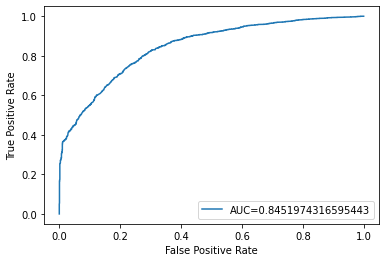

In [131]:
model_test = CatBoostClassifier(**trial.params)
use_model(model_test, X_train, y_train, X_test, y_test)
calculate_auc(model_2, X_val, y_val)


##Logistic Regression with PyTorch


In [132]:
class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs

In [133]:
epochs = 200000
input_dim = X_train.shape[1]
output_dim = 1 
learning_rate = 0.01

In [134]:
model_4 = LogisticRegression(input_dim,output_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=learning_rate)

In [135]:
X_train_py, X_val_py = torch.Tensor(X_train.to_numpy()),torch.Tensor(X_val.to_numpy())
y_train_py, y_val_py = torch.Tensor(y_train.to_numpy()),torch.Tensor(y_val.to_numpy())

In [136]:
losses = []
losses_test = []
Iterations = []
iter = 0
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = X_train_py
    labels = y_train_py
    optimizer.zero_grad() 
    outputs = model_4(X_train_py)
    loss = criterion(torch.squeeze(outputs), labels) 
    
    loss.backward() 
    
    optimizer.step() 
    
    iter+=1
    if iter%10000==0:
        with torch.no_grad():
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(model_4(X_val_py))
            loss_test = criterion(outputs_test, y_val_py)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_val_py.size(0)
            correct_test += np.sum(predicted_test == y_val_py.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())

            total = 0
            correct = 0
            total += y_train_py.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train_py.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Training Epochs:   5%|▌         | 10292/200000 [00:04<01:52, 1681.48it/s]

Iteration: 10000. 
Test - Loss: 0.4672265350818634. Accuracy: 77.83208740655549
Train -  Loss: 0.4247460961341858. Accuracy: 79.45914844649022



Training Epochs:  10%|█         | 20444/200000 [00:09<01:08, 2606.15it/s]

Iteration: 20000. 
Test - Loss: 0.4673992991447449. Accuracy: 77.86083956296723
Train -  Loss: 0.4216688871383667. Accuracy: 79.63176064441888



Training Epochs:  15%|█▌        | 30393/200000 [00:13<01:02, 2701.65it/s]

Iteration: 30000. 
Test - Loss: 0.46795138716697693. Accuracy: 78.17711328349627
Train -  Loss: 0.42116832733154297. Accuracy: 79.91944764096662



Training Epochs:  20%|██        | 40327/200000 [00:17<01:25, 1870.77it/s]

Iteration: 40000. 
Test - Loss: 0.4682570993900299. Accuracy: 78.40713053479011
Train -  Loss: 0.42106711864471436. Accuracy: 80.09205983889528



Training Epochs:  25%|██▌       | 50373/200000 [00:22<00:57, 2581.13it/s]

Iteration: 50000. 
Test - Loss: 0.46840882301330566. Accuracy: 78.32087406555492
Train -  Loss: 0.4210450053215027. Accuracy: 80.09205983889528



Training Epochs:  30%|███       | 60295/200000 [00:26<00:52, 2674.22it/s]

Iteration: 60000. 
Test - Loss: 0.46848058700561523. Accuracy: 78.29212190914319
Train -  Loss: 0.4210399389266968. Accuracy: 80.20713463751439



Training Epochs:  35%|███▌      | 70499/200000 [00:30<00:49, 2639.31it/s]

Iteration: 70000. 
Test - Loss: 0.46851658821105957. Accuracy: 78.26336975273145
Train -  Loss: 0.42103877663612366. Accuracy: 80.20713463751439



Training Epochs:  40%|████      | 80322/200000 [00:35<01:05, 1825.91it/s]

Iteration: 80000. 
Test - Loss: 0.4685336649417877. Accuracy: 78.26336975273145
Train -  Loss: 0.42103856801986694. Accuracy: 80.26467203682394



Training Epochs:  45%|████▌     | 90335/200000 [00:39<00:42, 2594.96it/s]

Iteration: 90000. 
Test - Loss: 0.4685406982898712. Accuracy: 78.26336975273145
Train -  Loss: 0.4210384786128998. Accuracy: 80.26467203682394



Training Epochs:  50%|█████     | 100290/200000 [00:43<00:38, 2584.06it/s]

Iteration: 100000. 
Test - Loss: 0.4685406982898712. Accuracy: 78.26336975273145
Train -  Loss: 0.4210384786128998. Accuracy: 80.26467203682394



Training Epochs:  55%|█████▌    | 110210/200000 [00:47<00:48, 1865.74it/s]

Iteration: 110000. 
Test - Loss: 0.4685406982898712. Accuracy: 78.26336975273145
Train -  Loss: 0.4210384786128998. Accuracy: 80.26467203682394



Training Epochs:  60%|██████    | 120368/200000 [00:53<00:35, 2237.33it/s]

Iteration: 120000. 
Test - Loss: 0.4685406982898712. Accuracy: 78.26336975273145
Train -  Loss: 0.4210384786128998. Accuracy: 80.26467203682394



Training Epochs:  65%|██████▌   | 130450/200000 [00:57<00:26, 2611.35it/s]

Iteration: 130000. 
Test - Loss: 0.4685406982898712. Accuracy: 78.26336975273145
Train -  Loss: 0.4210384786128998. Accuracy: 80.26467203682394



Training Epochs:  70%|███████   | 140406/200000 [01:01<00:24, 2446.57it/s]

Iteration: 140000. 
Test - Loss: 0.4685406982898712. Accuracy: 78.26336975273145
Train -  Loss: 0.4210384786128998. Accuracy: 80.26467203682394



Training Epochs:  75%|███████▌  | 150344/200000 [01:06<00:19, 2612.39it/s]

Iteration: 150000. 
Test - Loss: 0.4685406982898712. Accuracy: 78.26336975273145
Train -  Loss: 0.4210384786128998. Accuracy: 80.26467203682394



Training Epochs:  80%|████████  | 160396/200000 [01:10<00:15, 2517.53it/s]

Iteration: 160000. 
Test - Loss: 0.4685406982898712. Accuracy: 78.26336975273145
Train -  Loss: 0.4210384786128998. Accuracy: 80.26467203682394



Training Epochs:  85%|████████▌ | 170325/200000 [01:14<00:11, 2654.49it/s]

Iteration: 170000. 
Test - Loss: 0.4685406982898712. Accuracy: 78.26336975273145
Train -  Loss: 0.4210384786128998. Accuracy: 80.26467203682394



Training Epochs:  90%|█████████ | 180325/200000 [01:19<00:11, 1773.59it/s]

Iteration: 180000. 
Test - Loss: 0.4685406982898712. Accuracy: 78.26336975273145
Train -  Loss: 0.4210384786128998. Accuracy: 80.26467203682394



Training Epochs:  95%|█████████▌| 190444/200000 [01:23<00:03, 2596.87it/s]

Iteration: 190000. 
Test - Loss: 0.4685406982898712. Accuracy: 78.26336975273145
Train -  Loss: 0.4210384786128998. Accuracy: 80.26467203682394



Training Epochs: 100%|██████████| 200000/200000 [01:28<00:00, 2250.02it/s]

Iteration: 200000. 
Test - Loss: 0.4685406982898712. Accuracy: 78.26336975273145
Train -  Loss: 0.4210384786128998. Accuracy: 80.26467203682394

